# **Semantic Segmentation Competition (30%)**

For this competition, we will use a small autonomous driving dataset. The dataset contains 150 training images and 50 testing images.

We provide baseline code that includes the following features:

*    Loading the dataset using PyTorch.
*    Defining a simple convolutional neural network for semantic segmentation.
*    How to use existing loss function for the model learning.
*    Train the network on the training data.
*    Test the trained network on the testing data.

The following changes could be considered:
-------
1. Data augmentation
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, and Drop-out.
3. Architectural changes: Batch Normalization, Residual layers, etc.
4. Use of a new loss function.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



# 1. Download data and set configs

In [1]:
##################################################################################################################################
### Subject: Computer VisionSemantic Segmentation
### Year: 2025
### Student Name: Ge Wang, XYZ
### Student ID: a1880714, a654321
### Comptetion Name:  Competition
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

In [2]:
#1.1 Download the dataset.
# dowanload and unzip the dataset

In [3]:
#1.2 Set configs
#Use Colab or install PyTorch 1.9 on your local machine to run the code.
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tf
from PIL import Image
import shutil
from torch.utils.data import Dataset, DataLoader

#--------Data path----------
# Use your data path to replace the following path if you use Google drive.
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
# dataFolder = '/content/drive/MyDrive/Datasets/seg_data'
# dataFolder = './seg_data' # local path if you run the code on your local machine.
dataFolder = '/kaggle/input/seg-data/seg_data'  #kaggle input path

# To access Google Colab GPU; Go To: Edit >>> Notebook Settings >>> Hardware Accelarator: Select GPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: {}'.format(device))

#---------Config----------
learning_rate = 3e-4 #Tips: design a strategy to adjust the learning rate
# learning_rate = 1e-3 # can be adjusted
width = 864 # image width and height
height = 256 #
# batchSize = 4 #can be adjusted
batchSize = 2 # can be adjusted
# batchSize = 8 
epochs = 180 #can be adjusted

# if not os.path.exists(dataFolder):
#    print('Data Path Error! Pls check your data path')
if not torch.cuda.is_available():
  print('WARNING! The device is CPU NOT GPU! Pls avoid using CPU for training')

device: cuda


# 2. Define a dataloader to load data

In [4]:
#The class to load images and labels
class ExpDataSet(Dataset):
    def __init__(self, dataFolder):
        self.image_path = os.listdir(os.path.join(dataFolder, "training/image"))
        self.label_path = os.listdir(os.path.join(dataFolder, "training/image"))#Image name only
        print('load info for {} images'.format(len(self.image_path)))
        assert len(self.image_path) == 150
        for idx in range(0, len(self.image_path)):
            assert self.image_path[idx] == self.label_path[idx] #same
            self.image_path[idx] = os.path.join(dataFolder, "training/image", self.image_path[idx])
            self.label_path[idx] = os.path.join(dataFolder, "training/label", self.label_path[idx])
        # --------------------Transformation functions----------------
        #-------------Tips: data augmentation can be used (for example flip, resize)-------------
        self.transformImg = tf.Compose([tf.ToPILImage(), 
                                        # tf.RandomRotation(5), # random rotation data augmentation
                                        # tf.GaussianBlur(kernel_size=3), # Gaussian blur data augmentation
                                        # tf.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),#color jitter data augmentation
                                        tf.Resize((height, width)), 
                                        tf.ToTensor(),
                                        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                        ])
        self.transformLabel = tf.Compose([tf.ToPILImage(), tf.Resize((height, width), tf.InterpolationMode.NEAREST)])
    def __getitem__(self, idx):
        img = cv2.imread(self.image_path[idx])[:, :, 0:3]
        label = cv2.imread(self.label_path[idx], 0)
        img = self.transformImg(img)  #3*H*W
        label = self.transformLabel(label)
        label = torch.tensor(np.array(label))  #H*W
        return img, label
    def __len__(self):
        return len(self.image_path)

#Get the predefined dataloader
exp_data = ExpDataSet(dataFolder)
train_loader = DataLoader(exp_data, batch_size=batchSize, shuffle=True, num_workers=2)

load info for 150 images


# 3. Define a convolutional neural network

In [ ]:
# #Define the semantic segmentation network. Tips: a new network can be used
# class SegNetwork(nn.Module):
#     def __init__(self, 
#                  n_class=19,
#                  use_residual=False,  #optional residual connection
#                  use_batch_norm=False,  #optional batch normalization
#                  ):
#         super(SegNetwork, self).__init__()
#         self.use_residual = use_residual  #optional residual connection
#         self.relu = nn.ReLU(inplace=True)
#         #stage 1
#         self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
#         if use_batch_norm:
#             self.bn1_1 = nn.BatchNorm2d(64, momentum=0.1)
#         self.relu1_1 = nn.ReLU(inplace=True)
#         self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
#         if use_batch_norm:
#             self.bn1_2 = nn.BatchNorm2d(64)
#         self.relu1_2 = nn.ReLU(inplace=True)
#         self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/2

#         # Residual block for stage 1
#         self.res_block1 = nn.Sequential(
#             nn.Conv2d(3, 64, 3, padding=1),
#             nn.BatchNorm2d(64, momentum=0.1),
#             nn.ReLU(inplace=True)
#         )

#         #stage 2
#         self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
#         if use_batch_norm:
#             self.bn2_1 = nn.BatchNorm2d(128)
#         self.relu2_1 = nn.ReLU(inplace=True)
#         self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
#         if use_batch_norm:
#             self.bn2_2 = nn.BatchNorm2d(128)
#         self.relu2_2 = nn.ReLU(inplace=True)
#         self.drop2_1 = nn.Dropout2d(p=0.1) #optional dropout
#         self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/4
#         # Residual block for stage 2
#         self.res_block2 = nn.Sequential(
#             nn.Conv2d(64, 128, 1),  # 1x1 conv to match channels
#             nn.BatchNorm2d(128, momentum=0.1),
#             nn.ReLU(inplace=True)
#         )

#         #stage 3
#         self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
#         if use_batch_norm:    
#             self.bn3_1 = nn.BatchNorm2d(256)
#         self.relu3_1 = nn.ReLU(inplace=True)
#         self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
#         if use_batch_norm:
#             self.bn3_2 = nn.BatchNorm2d(256)
#         self.relu3_2 = nn.ReLU(inplace=True)
#         self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/8
#         # Residual block for stage 3
#         self.res_block3 = nn.Sequential(
#             nn.Conv2d(128, 256, 1),  # 1x1 conv to match channels
#             nn.BatchNorm2d(256, momentum=0.1),
#             nn.ReLU(inplace=True)
#         )

#         #stage 4
#         self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
#         if use_batch_norm:
#             self.bn4_1 = nn.BatchNorm2d(512)
#         self.relu4_1 = nn.ReLU(inplace=True)
#         self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
#         if use_batch_norm:
#             self.bn4_2 = nn.BatchNorm2d(512)
#         self.relu4_2 = nn.ReLU(inplace=True)
#         self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/16
#         # Residual block for stage 4
#         self.res_block4 = nn.Sequential(
#             nn.Conv2d(256, 512, 1),  # 1x1 conv to match channels
#             nn.BatchNorm2d(512, momentum=0.1),
#             nn.ReLU(inplace=True)
#         )

#         #stage 5
#         # Bottleneck: Input 512 channels, Output 512 channels
#         self.conv5_1 = nn.Conv2d(512, 512, 3, padding=2, dilation=2)  # Dilated conv
#         self.bn5_1 = nn.BatchNorm2d(512, momentum=0.1) if use_batch_norm else None
#         self.relu5_1 = nn.ReLU(inplace=True)

#         # Upsampling path with skip connections
#         self.upsample_conv1 = nn.Conv2d(512, 256, 3, padding=1)
#         self.bn_up1 = nn.BatchNorm2d(256, momentum=0.1) if use_batch_norm else None
#         self.relu_up1 = nn.ReLU(inplace=True)

#         self.upsample_conv2 = nn.Conv2d(256, 128, 3, padding=1)
#         self.bn_up2 = nn.BatchNorm2d(128, momentum=0.1) if use_batch_norm else None
#         self.relu_up2 = nn.ReLU(inplace=True)

#         self.upsample_conv3 = nn.Conv2d(128, 64, 3, padding=1)
#         self.bn_up3 = nn.BatchNorm2d(64, momentum=0.1) if use_batch_norm else None
#         self.relu_up3 = nn.ReLU(inplace=True)

#         # Final convolution to produce segmentation map
#         self.final_conv = nn.Conv2d(64, n_class, 1)

#     def forward(self, x):
#         inp_shape = x.shape[2:]  # (256, 864)
#         # Stage 1
#         shortcut1 = x
#         x = self.relu(self.conv1_1(x))
#         x = self.relu(self.conv1_2(x))
#         if self.use_residual and self.res_block1 is not None:
#             x = x + self.res_block1(shortcut1)
#         skip1 = x
#         x = self.pool1(x)

#         # Stage 2
#         shortcut2 = x
#         x = self.relu(self.bn2_1(self.conv2_1(x)))
#         x = self.relu(self.bn2_2(self.conv2_2(x)))
#         if self.use_residual and self.res_block2 is not None:
#             x = x + self.res_block2(shortcut2)
#         skip2 = x
#         x = self.pool2(x)

#         # Stage 3
#         shortcut3 = x
#         x = self.relu(self.bn3_1(self.conv3_1(x)))
#         x = self.relu(self.bn3_2(self.conv3_2(x)))
#         if self.use_residual and self.res_block3 is not None:
#             x = x + self.res_block3(shortcut3)
#         skip3 = x
#         x = self.pool3(x)

#         # Stage 4
#         shortcut4 = x
#         x = self.relu(self.bn4_1(self.conv4_1(x)))
#         x = self.relu(self.bn4_2(self.conv4_2(x)))
#         if self.use_residual and self.res_block4 is not None:
#             x = x + self.res_block4(shortcut4)
#         x = self.pool4(x)

#         # Bottleneck
#         x = self.conv5_1(x)
#         if self.bn5_1 is not None:
#             x = self.bn5_1(x)
#         x = self.relu5_1(x)

#         # Upsampling path
#         x = F.interpolate(x, size=skip3.shape[2:], mode="bilinear", align_corners=True)
#         x = self.upsample_conv1(x)
#         if self.bn_up1 is not None:
#             x = self.bn_up1(x)
#         x = self.relu_up1(x)
#         x = x + skip3

#         x = F.interpolate(x, size=skip2.shape[2:], mode="bilinear", align_corners=True)
#         x = self.upsample_conv2(x)
#         if self.bn_up2 is not None:
#             x = self.bn_up2(x)
#         x = self.relu_up2(x)
#         x = x + skip2

#         x = F.interpolate(x, size=skip1.shape[2:], mode="bilinear", align_corners=True)
#         x = self.upsample_conv3(x)
#         if self.bn_up3 is not None:
#             x = self.bn_up3(x)
#         x = self.relu_up3(x)
#         x = x + skip1

#         # Final convolution
#         x = self.final_conv(x)
#         x = F.interpolate(x, size=inp_shape, mode="bilinear", align_corners=True)
#         return x  # [batch_size, 19, 256, 864]

# #Get the predefined network
# segNet = SegNetwork(n_class=19,
#                     use_residual=True,  #optional residual connection
#                     use_batch_norm=True  #optional batch normalization
#                     ).to(device)

# If using MobileNetV3 backbone


In [ ]:
import torchvision
# Load DeepLabV3 with MobileNetV3 backbone
segNet = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
    weights=None,  # or 'DEFAULT' for pretrained on COCO
    num_classes=19  
).to(device)

# 4. Define a loss function and optimizer

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        inputs = inputs.argmax(dim=1)
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce(inputs, targets)
        pt = torch.exp(logpt)
        loss = ((1 - pt) ** self.gamma) * -logpt
        return loss.mean()

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1.0):
        super(HybridLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=255, weight=torch.tensor([1.0]*19).to(device))  # Adjust weights
        self.dice = DiceLoss(smooth=smooth)
        self.alpha = alpha
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.alpha * ce_loss + (1 - self.alpha * dice_loss)


# Foe Cross Entropy Loss:
# criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
# For Dice Loss:
# criterion = DiceLoss()
# For Focal Loss:
# criterion = FocalLoss(gamma=1.5, weight=torch.tensor([1.0, 2.0, ...]).to(device))
# for Hybrid Loss:
criterion = HybridLoss(alpha=0.7)


# Define the optimizer
# optimizer = torch.optim.Adam(params=segNet.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(params=segNet.parameters(), lr=learning_rate, weight_decay=1e-4)
# for SGD optimizer:
# optimizer = torch.optim.SGD(params=segNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) #Adding a learning rate scheduler

# 5. The function used to compare the precision

In [7]:
#------------------Modification of this function is ***NOT*** allowed---------------
def cal_acc(pred_folder, gt_folder, classes=19):
    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def intersectionAndUnion(output, target, K, ignore_index=255):
        assert (output.ndim in [1, 2, 3])
        assert output.shape == target.shape
        output = output.reshape(output.size).copy()
        target = target.reshape(target.size)
        output[np.where(target == ignore_index)[0]] = ignore_index
        intersection = output[np.where(output == target)[0]]
        area_intersection, _ = np.histogram(intersection, bins=np.arange(K + 1))
        area_output, _ = np.histogram(output, bins=np.arange(K + 1))
        area_target, _ = np.histogram(target, bins=np.arange(K + 1))
        area_union = area_output + area_target - area_intersection
        return area_intersection, area_union, area_target
    data_list = os.listdir(gt_folder)
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    for i, image_name in enumerate(data_list):
        pred = cv2.imread(os.path.join(pred_folder, image_name), cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(os.path.join(gt_folder, image_name), cv2.IMREAD_GRAYSCALE)
        intersection, union, target = intersectionAndUnion(pred, target, classes)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    print('Eval result: mIoU {:.4f}.'.format(mIoU))
    return mIoU

# 6. Define functions to get and save predictions

In [ ]:
# def make_folder(dir_name):#make a folder
#     if not os.path.exists(dir_name):
#         os.makedirs(dir_name)

# def move_folders(grey_temp, color_temp, grey_rs, color_rs):#move folders
#     if os.path.exists(grey_temp):
#         make_folder(grey_rs)
#         for file in os.listdir(grey_temp):
#             shutil.move(os.path.join(grey_temp, file), os.path.join(grey_rs, file))
#         if os.path.exists(grey_temp):
#             shutil.rmtree(grey_temp)
#     if os.path.exists(color_temp):
#         make_folder(color_rs)
#         for file in os.listdir(color_temp):
#             shutil.move(os.path.join(color_temp, file), os.path.join(color_rs, file))
#         if os.path.exists(color_temp):
#             shutil.rmtree(color_temp)

# def colorize(gray, palette):#visualize predictions results
#     color = Image.fromarray(gray.astype(np.uint8)).convert('P')
#     color.putpalette(palette)
#     return color

# #-------Perform evaluation for a network and save prediction results--------
# def get_predictions(segNet, dataFolder, device):#params: a network, data path, device
#     gray_folder, color_folder = './temp_grey', './temp_color'
#     listImages, gt_folder = os.listdir(os.path.join(dataFolder, "testing/image")), os.path.join(dataFolder, "testing/label")
#     colors_path  = os.path.join(dataFolder, "colors.txt") #colors for visualizing greyscale images
#     print('Begin testing')
#     make_folder(gray_folder)
#     make_folder(color_folder)
#     colors = np.loadtxt(colors_path).astype('uint8')
#     #Tips: muti-scale testing can be used
#     transformTest = tf.Compose([tf.ToPILImage(), tf.ToTensor(),
#                                 tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#     for idx in range(0, len(listImages)):
#         img = cv2.imread(os.path.join(dataFolder, "testing/image", listImages[idx]))[:, :, 0:3]
#         img = transformTest(img).unsqueeze(0)  #1*3*H*W
#         prediction = segNet(img.to(device))
#         prediction = prediction[0].cpu().detach().numpy()
#         prediction = np.argmax(prediction, axis=0)
#         gray = np.uint8(prediction)
#         color = colorize(gray, colors)
#         gray_path = os.path.join(gray_folder, listImages[idx])
#         color_path = os.path.join(color_folder, listImages[idx])
#         cv2.imwrite(gray_path, gray)
#         color.save(color_path)
#     return gray_folder, color_folder #return folders (paths) which contain grey and color predictions.

# Get predictions when using MobileNetV3

In [ ]:
def make_folder(dir_name):#make a folder
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

def move_folders(grey_temp, color_temp, grey_rs, color_rs):#move folders
    if os.path.exists(grey_temp):
        make_folder(grey_rs)
        for file in os.listdir(grey_temp):
            shutil.move(os.path.join(grey_temp, file), os.path.join(grey_rs, file))
        if os.path.exists(grey_temp):
            shutil.rmtree(grey_temp)
    if os.path.exists(color_temp):
        make_folder(color_rs)
        for file in os.listdir(color_temp):
            shutil.move(os.path.join(color_temp, file), os.path.join(color_rs, file))
        if os.path.exists(color_temp):
            shutil.rmtree(color_temp)

def colorize(gray, palette):#visualize predictions results
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')
    color.putpalette(palette)
    return color

#-------Perform evaluation for a network and save prediction results--------
def get_predictions(segNet, dataFolder, device):#params: a network, data path, device
    gray_folder, color_folder = './temp_grey', './temp_color'
    listImages, gt_folder = os.listdir(os.path.join(dataFolder, "testing/image")), os.path.join(dataFolder, "testing/label")
    colors_path  = os.path.join(dataFolder, "colors.txt") #colors for visualizing greyscale images
    print('Begin testing')
    make_folder(gray_folder)
    make_folder(color_folder)
    colors = np.loadtxt(colors_path).astype('uint8')
    #Tips: muti-scale testing can be used
    transformTest = tf.Compose([tf.ToPILImage(), tf.ToTensor(),
                                tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    for idx in range(0, len(listImages)):
        img = cv2.imread(os.path.join(dataFolder, "testing/image", listImages[idx]))[:, :, 0:3]
        img = transformTest(img).unsqueeze(0)  #1*3*H*W
        output = segNet(img.to(device))
        prediction = output['out'][0].cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=0)
        gray = np.uint8(prediction)
        color = colorize(gray, colors)
        gray_path = os.path.join(gray_folder, listImages[idx])
        color_path = os.path.join(color_folder, listImages[idx])
        cv2.imwrite(gray_path, gray)
        color.save(color_path)
    return gray_folder, color_folder #return folders (paths) which contain grey and color predictions.

# 7. Train the network

In [ ]:
# #The training will take ~1 h.
# mIoU = 0.0
# IoU_list = []
# train_loss = []
# evl_each = True #Perform evaluation after each epoch. You can define the false case to save training time
# patience = 10  # Number of epochs to wait for improvement
# best_mIoU = 0.0
# epochs_no_improve = 0

# for epoch in range(epochs):
#     for iter, (imgs, labels) in enumerate(train_loader):
#         pred = segNet(imgs.to(device))
#         segNet.zero_grad()
#         loss = criterion(pred, labels.long().to(device)) #calculate the loss
#         train_loss.append(loss.detach().cpu().numpy().item())
#         loss.backward()
#         optimizer.step()
#         print('epoch {} iter {} loss={}'.format(epoch, iter, loss.data.cpu().numpy()))

# #-----Evaluation------
#     if evl_each and epoch > 100:
#         segNet.eval()
#         gray_folder, color_folder = get_predictions(segNet, dataFolder, device)
#         segNet.train()
#         temp_mIoU = cal_acc(gray_folder, os.path.join(dataFolder, 'testing/label'))
#         IoU_list.append(temp_mIoU)
#         if temp_mIoU > best_mIoU:
#             best_mIoU = temp_mIoU
#             epochs_no_improve = 0
#             torch.save(segNet.state_dict(), './model.pth')
#             move_folders(gray_folder, color_folder,
#                          gray_folder.replace('temp_', ''),
#                          color_folder.replace('temp_', ''))
#         else:
#             epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print(f"Early stopping at epoch {epoch}. Best mIoU: {best_mIoU:.4f}")
#             break
#     scheduler.step() #Update the learning rate
    
# print('The final mIoU is : {:.4f}.'.format(best_mIoU)) #The final mIoU is ~0.28
# #Remember to download the results before closing the tab!

epoch 0 iter 0 loss=3.114506721496582
epoch 0 iter 1 loss=2.5222742557525635
epoch 0 iter 2 loss=2.324031352996826
epoch 0 iter 3 loss=2.265740394592285
epoch 0 iter 4 loss=2.9498250484466553
epoch 0 iter 5 loss=2.2172892093658447
epoch 0 iter 6 loss=2.3464770317077637
epoch 0 iter 7 loss=2.0761032104492188
epoch 0 iter 8 loss=2.300729513168335
epoch 0 iter 9 loss=2.2782065868377686
epoch 0 iter 10 loss=2.088123083114624
epoch 0 iter 11 loss=2.0340964794158936
epoch 0 iter 12 loss=1.5776695013046265
epoch 0 iter 13 loss=1.758310079574585
epoch 0 iter 14 loss=2.2154977321624756
epoch 0 iter 15 loss=1.60309636592865
epoch 0 iter 16 loss=1.628210186958313
epoch 0 iter 17 loss=2.5002598762512207
epoch 0 iter 18 loss=1.4892181158065796
epoch 0 iter 19 loss=1.6233763694763184
epoch 0 iter 20 loss=1.5020848512649536
epoch 0 iter 21 loss=1.0323553085327148
epoch 0 iter 22 loss=1.8917276859283447
epoch 0 iter 23 loss=1.4486116170883179
epoch 0 iter 24 loss=1.9124151468276978
epoch 0 iter 25 los

# If using MobileNetV3 backbone to train

In [ ]:
#The training will take ~1 h.
mIoU = 0.0
IoU_list = []
train_loss = []
evl_each = True #Perform evaluation after each epoch. You can define the false case to save training time
patience = 20  # Number of epochs to wait for improvement
best_mIoU = 0.0
epochs_no_improve = 0

for epoch in range(epochs):
    for iter, (imgs, labels) in enumerate(train_loader):
        output = segNet(imgs.to(device))
        pred = output['out']  # Get the segmentation output
        segNet.zero_grad()
        loss = criterion(pred, labels.long().to(device)) #calculate the loss
        train_loss.append(loss.detach().cpu().numpy().item())
        loss.backward()
        optimizer.step()
        print('epoch {} iter {} loss={}'.format(epoch, iter, loss.data.cpu().numpy()))

#-----Evaluation------
    if evl_each and epoch > 100:
        segNet.eval()
        gray_folder, color_folder = get_predictions(segNet, dataFolder, device)
        segNet.train()
        temp_mIoU = cal_acc(gray_folder, os.path.join(dataFolder, 'testing/label'))
        IoU_list.append(temp_mIoU)
        if temp_mIoU > best_mIoU:
            best_mIoU = temp_mIoU
            epochs_no_improve = 0
            torch.save(segNet.state_dict(), './model.pth')
            move_folders(gray_folder, color_folder,
                         gray_folder.replace('temp_', ''),
                         color_folder.replace('temp_', ''))
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best mIoU: {best_mIoU:.4f}")
            break
    scheduler.step() #Update the learning rate
    
print('The final mIoU is : {:.4f}.'.format(best_mIoU)) #The final mIoU is ~0.28
#Remember to download the results before closing the tab!

In [10]:
from matplotlib import pyplot as plt

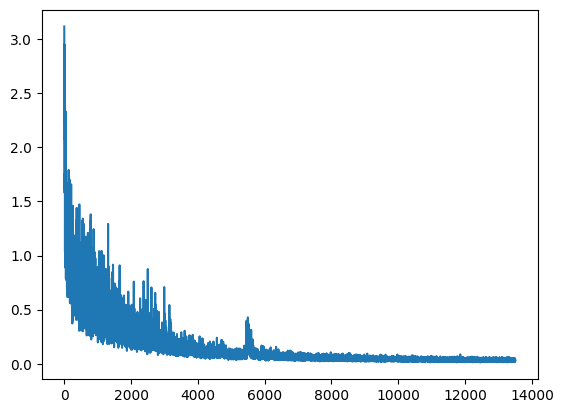

In [11]:
plt.plot(train_loss,label="train_loss")

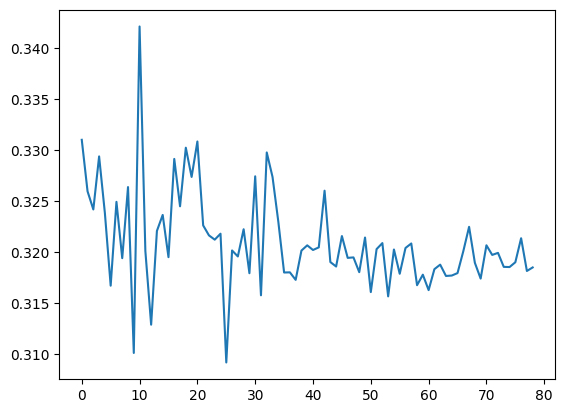

In [12]:
plt.plot(IoU_list,label="IoU")


A prediction example by using the baseline:

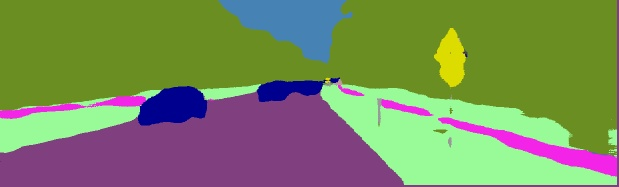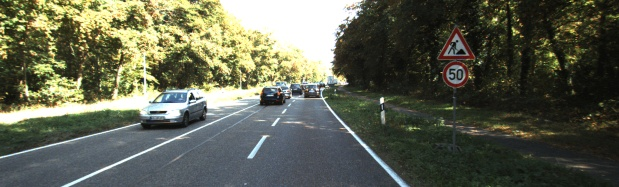

# 8. FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [13]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=3d7a7cf81213f8a81109e86c86597f500d7c79b8f884f3173011da0c2de403de
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=6fe9d535b09cc5c69b369eb34f0bd10728de4eff86c94270430614383b737141
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [ ]:
# from fvcore.nn import FlopCountAnalysis
# input = torch.randn(1, 3, 375, 1242) # Modifying the size (3, 375, 1242) is ***NOT*** allowed.

# # Get the network and its FLOPs
# model = SegNetwork(n_class=19, use_batch_norm=True)
# flops = FlopCountAnalysis(model, input)
# print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

FLOPs: 204.83 GFLOPs


# GFLOPs for MobileNetV3

In [ ]:
from fvcore.nn import FlopCountAnalysis
import torch

input = torch.randn(1, 3, 375, 1242).to(device)  # Do NOT change the size

# Pass the model directly, not a lambda
segNet.eval()  # Set to eval mode for FLOPs calculation
with torch.no_grad():
    flops = FlopCountAnalysis(segNet, input)
    print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

## Ablation Study Table
| Data Augmentation         | Training Params                     | Architecture                     | Loss Function | mIoU (%) | GFLOPs |
|--------------------------|------------------------------------|----------------------------------|---------------|----------|--------|
| None                     | Adam, lr=3e-4, BS=4 | Baseline                         | CrossEntropy  |     0.286     |       66.97     |
| Crop+Rot+Blur+Jitter      | AdamW, lr=3e-4, BS=2, CosineAnneal | Baseline                         | CrossEntropy  |          |          |
| Crop+Rot+Blur+Jitter      | AdamW, lr=3e-4, BS=2, CosineAnneal | BatchNorm+Residual+Skip+Dilated          | CrossEntropy  |     0.3421     |      204.83     |
| Crop+Rot+Blur+Jitter      | AdamW, lr=3e-4, BS=2, CosineAnneal | BatchNorm+Residual+Skip+Dilated  | Hybrid        |     0.2125     |          |
| Crop+Rot+Blur+Jitter      | AdamW, lr=3e-4, BS=2, CosineAnneal | MobileNetV3+BatchNorm+Skip       | CrossEntropy        |     0.3377     |     18.10      |
| Crop+Rot+Blur+Jitter      | AdamW, lr=3e-4, BS=2, CosineAnneal | MobileNetV3+BatchNorm+Skip       | Hybrid        |          |           |